# Gradient Boosting Methods

## Initialization

In [1]:
#Data processing
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model and performance
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor, plot_importance

## Load Data

In [2]:
df = pd.read_csv('/datasets/car_data.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

## EDA

In [5]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


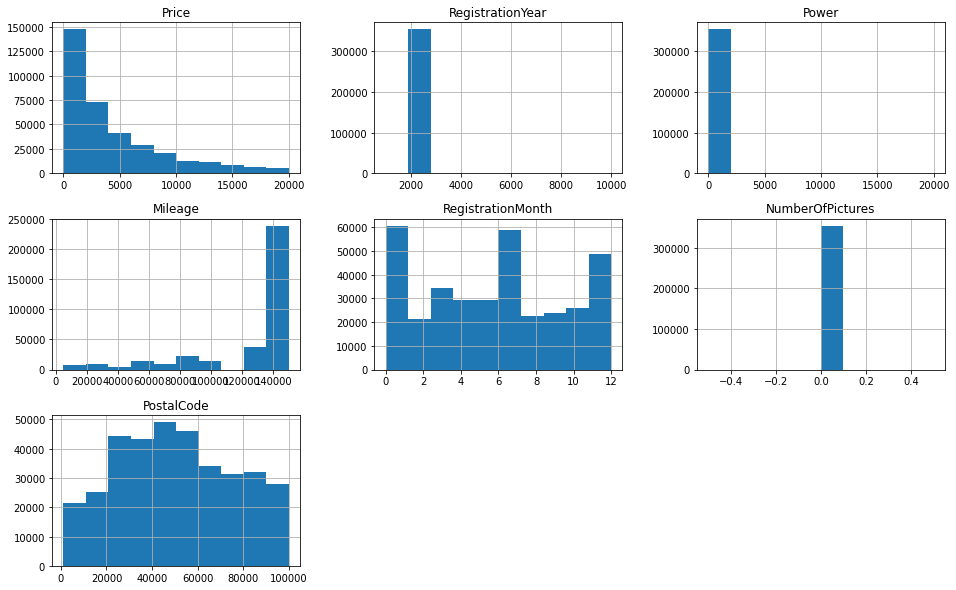

In [6]:
# Plot histograms of each quant variable
df.hist(figsize=(16,10))
plt.show()

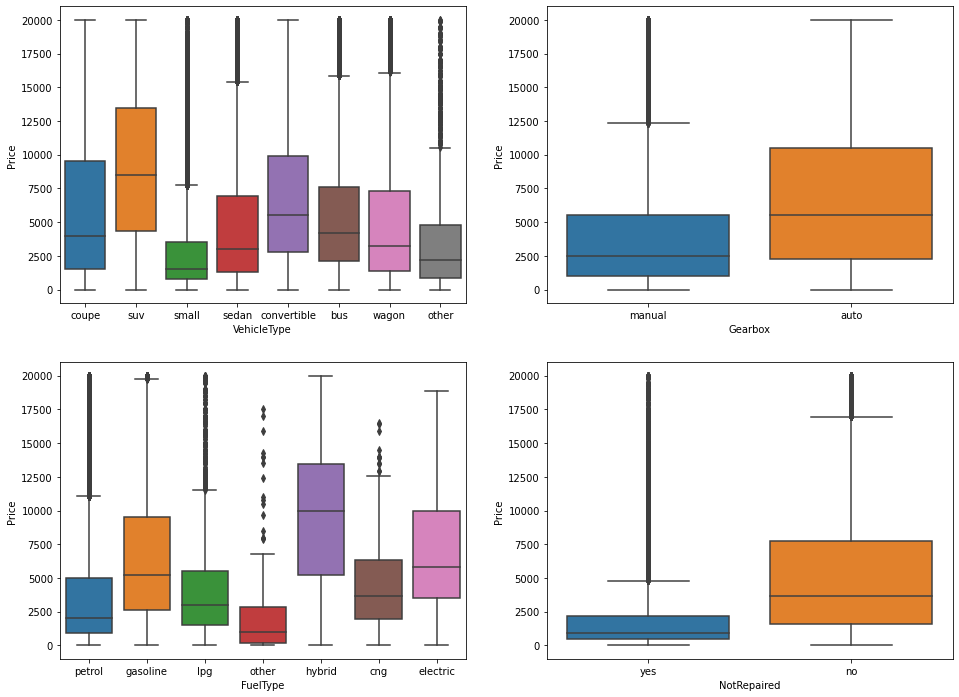

In [7]:
# Plot boxplots of categorical variables against the target: Price
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
sns.boxplot(data=df, x="VehicleType", y="Price")
plt.subplot(2,2,2)
sns.boxplot(data=df, x="Gearbox", y="Price")

plt.subplot(2,2,3)
sns.boxplot(data=df, x="FuelType", y="Price")
plt.subplot(2,2,4)
sns.boxplot(data=df, x="NotRepaired", y="Price")
plt.show()

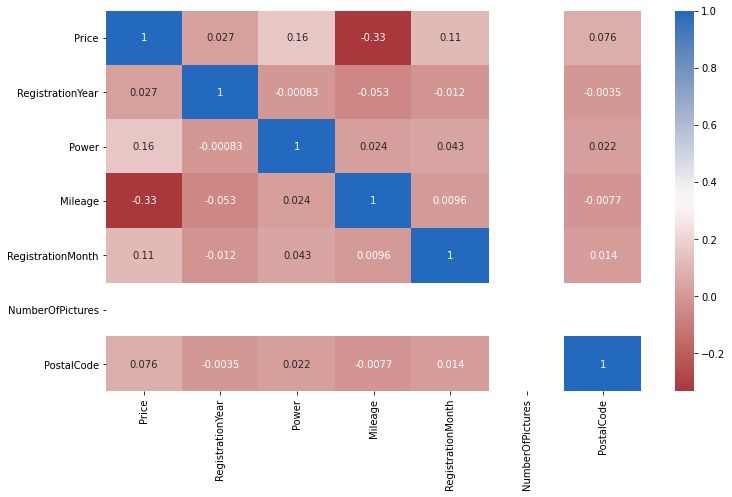

In [8]:
# Plot the correlation (R2) of each quantitative variable with the target: Price
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(), annot=True, cmap='vlag_r')
plt.show()

**Conclusions**
- The target variable `price` is positively skewed
- The `number of pictures` variable contains only 1 value, it can be dropped from the features
- Mileage has a weak negative correlation with price

## Data preparation

In [9]:
# Rename cols
df.columns = df.columns.str.lower()

In [10]:
# Check for duplicates
df.duplicated().sum()

262

In [11]:
# Drop duplicates
df = df.drop_duplicates().reset_index(drop=True)

### Missing values

In [12]:
# Check for missing values (Percent of total observations)
missing_values = df.isna().sum()/len(df)*100
missing_values[missing_values != 0]

vehicletype    10.585501
gearbox         5.600002
model           5.563573
fueltype        9.287871
notrepaired    20.091385
dtype: float64

In [13]:
# Check if should fill in NaNs with another value or drop
df.vehicletype.value_counts(dropna=False)

sedan          91399
small          79753
wagon          65115
NaN            37484
bus            28752
convertible    20180
coupe          16147
suv            11991
other           3286
Name: vehicletype, dtype: int64

In [14]:
df.gearbox.value_counts(dropna=False)

manual    268034
auto       66243
NaN        19830
Name: gearbox, dtype: int64

In [15]:
df.model.value_counts(dropna=False)

golf                  29215
other                 24402
3er                   19744
NaN                   19701
polo                  13057
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 251, dtype: int64

In [16]:
df.fueltype.value_counts(dropna=False)

petrol      216161
gasoline     98658
NaN          32889
lpg           5307
cng            565
hybrid         233
other          204
electric        90
Name: fueltype, dtype: int64

In [17]:
df.notrepaired.value_counts(dropna=False)

no     246927
NaN     71145
yes     36035
Name: notrepaired, dtype: int64

In [18]:
df.shape

(354107, 16)

In [19]:
df.dropna().shape

(245567, 16)

In [20]:
# Drop NaNs
df = df.dropna()

In [21]:
# Drop date cols
df = df.drop(['datecrawled', 'datecreated', 'lastseen'], axis=1)

In [22]:
# Drop number of pictures col since they're all zero
df = df.drop('numberofpictures', axis=1)

In [23]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,postalcode
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,67112
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,19348


### Feature Encoding

#### OHE

Only used in linear regression

In [143]:
categorical = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

In [144]:
df_ohe = pd.get_dummies(df, columns=categorical, drop_first=True)
df_ohe.head()

,price,registrationyear,power,mileage,registrationmonth,postalcode,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,...,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_yes
3,1500,2001,75,150000,6,91074,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,7,60437,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,650,1995,102,150000,10,33775,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6,2200,2004,109,150000,8,67112,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1980,50,40000,7,19348,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [145]:
df_ohe.shape

(245567, 307)

In [146]:
# Set features and target
X_ohe = df_ohe.drop('price', axis=1)
y_ohe = df_ohe['price']

#### Label Encoding

Used in tree-based and gradient boosing models (Decision Tree, Random Forest, LightGBM, CatBoost, XGBoost)

In [57]:
encoder = OrdinalEncoder()

df_ordinal = pd.DataFrame(encoder.fit_transform(df), columns=df.columns)
df_ordinal.head()

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,postalcode
0,579.0,5.0,65.0,1.0,75.0,116.0,12.0,6.0,6.0,37.0,0.0,6974.0
1,1146.0,5.0,72.0,1.0,69.0,101.0,9.0,7.0,2.0,31.0,0.0,4170.0
2,271.0,4.0,59.0,1.0,102.0,11.0,12.0,10.0,6.0,2.0,1.0,2341.0
3,777.0,1.0,68.0,1.0,109.0,8.0,12.0,8.0,6.0,25.0,0.0,4593.0
4,0.0,4.0,44.0,1.0,50.0,166.0,4.0,7.0,6.0,37.0,0.0,1143.0


In [58]:
df_ordinal.shape

(245567, 12)

In [59]:
# Set features and target
X_ordinal = df_ordinal.drop('price', axis=1)
y_ordinal = df_ordinal['price']

## Model training

In [60]:
def model_evaluation(model, features_test, target_test):
    # Predictions
    pred_test = model.predict(features_test)
    
    # Evaluation Metric
    rmse = mean_squared_error(target_test, pred_test, squared=False)
    return rmse
    #print(f'{model_name} RMSE: {rmse:.2f}')

### Linear Regression (baseline)

In [147]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y_ohe, test_size=0.25, random_state=0)

In [148]:
# Initialize Scaler
scaler = StandardScaler()

# Scale features
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [149]:
# Initialize model 
model_lr = LinearRegression()

In [150]:
%%time
# Train the model with scaled data
model_lr.fit(X_train_scaled,y_train)

CPU times: user 12.1 s, sys: 2.02 s, total: 14.1 s
Wall time: 14.1 s


LinearRegression()

In [151]:
%%time
rmse_lr = model_evaluation(model_lr, X_test_scaled, y_test)
print(f'Logistic Regression RMSE: {rmse_lr:.2f}')

Logistic Regression RMSE: 2722.28
CPU times: user 32.9 ms, sys: 47.8 ms, total: 80.7 ms
Wall time: 98.8 ms


In [153]:
# Save wall time as variable
train_time_lr = 14.1
predict_time_lr = 98.8e-3

### Decision Tree Regressor

In [67]:
# Split the label encoded data
X_train, X_test, y_train, y_test = train_test_split(X_ordinal, y_ordinal, test_size=0.25, random_state=0)

In [69]:
%%time
# RandomizedSearchCV to tune hyperparameters
# Initialize model
model = DecisionTreeRegressor(random_state=0)

# Set possible parameters
params = {
    'max_depth': [3, 5, 7, 9, 11, 13, None],
    'max_leaf_nodes': [3, 6, 9, None],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
 }

random = RandomizedSearchCV(model, param_distributions=params, scoring='neg_mean_squared_error', random_state=0, n_jobs=-1)
random.fit(X_train, y_train)

# Best hyperparameters
print(f'Best hyperparameters:, {random.best_params_}')

# save best model
model_dt = random.best_estimator_

Best hyperparameters:, {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'max_depth': 9}
CPU times: user 18.1 s, sys: 0 ns, total: 18.1 s
Wall time: 18.1 s


In [109]:
%%time
rmse_dt = model_evaluation(model_dt, X_test, y_test)
print(f'Decision Tree Regressor RMSE: {rmse_dt:.2f}')

Decision Tree Regressor RMSE: 384.20
CPU times: user 12.1 ms, sys: 1e+03 ns, total: 12.1 ms
Wall time: 9.84 ms


In [110]:
# Save wall time as variable (in seconds)
train_time_dt = 18.1
predict_time_dt = 9.84e-3

### Random Forest Regressor

In [72]:
%%time
# RandomizedSearchCV to tune hyperparameters
model = RandomForestRegressor(random_state=0)

# Set possible parameters
params = {
    'n_estimators' : [20, 40, 60, 80, 100],
    'max_depth': [3, 5, 7, 9, 11, None],
    'max_leaf_nodes': [3, 6, 9, None],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
 }

random = RandomizedSearchCV(model, param_distributions=params, scoring='neg_mean_squared_error', random_state=0, n_jobs=-1)
random.fit(X_train, y_train)

# Best hyperparameters
print(f'Best hyperparameters:, {random.best_params_}')

# Save best model
model_rfr = random.best_estimator_

Best hyperparameters:, {'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'max_depth': 9}
CPU times: user 13min 21s, sys: 217 ms, total: 13min 21s
Wall time: 13min 21s


In [111]:
%%time
rmse_rf = model_evaluation(model_rfr, X_test, y_test)
print(f'Random Forest Regressor RMSE: {rmse_rf:.2f}')

Random Forest Regressor RMSE: 367.25
CPU times: user 600 ms, sys: 70 µs, total: 600 ms
Wall time: 598 ms


In [112]:
# Save wall time as variable (in seconds)
train_time_rf = 13*60 + 21
predict_time_rf = 598e-3

### LightGBM

In [76]:
%%time
# Tune a couple of hyperparameters to find best model
best_model_lgb = None
best_est = 0
best_depth = 0
score = 10e6

# Find best hyperparameters for n_estimators and max_depth
for est in [100,500,1000]:
    for depth in [2, 4, 6]:
        model = lgb.LGBMRegressor(n_estimators=est, max_depth=depth, random_state=0)
        model.fit(X_train, y_train)
        predict_test = model.predict(X_test)
        rmse = mean_squared_error(y_test, predict_test, squared=False)
        if rmse < score:
            score = rmse
            best_depth = depth
            best_est = est
            best_model_lgb = model
            
#print(f'Best LightGBM RMSE: {score}')
print(f'Best parameters: n_estimators={best_est}, max_depth={best_depth}')

Best parameters: n_estimators=1000, max_depth=6
CPU times: user 1min 53s, sys: 261 ms, total: 1min 53s
Wall time: 1min 54s


In [113]:
%%time
rmse_lgb = model_evaluation(best_model_lgb, X_test, y_test)
print(f'LightGBM RMSE: {rmse_lgb:.2f}')

LightGBM RMSE: 298.97
CPU times: user 6.29 s, sys: 0 ns, total: 6.29 s
Wall time: 6.3 s


In [121]:
# Save wall time as variable (in seconds)
train_time_lgb = 60 + 54
predict_time_lgb = 6.3

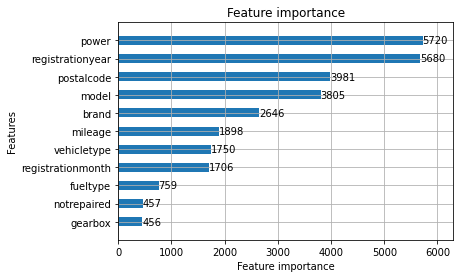

In [79]:
# plotting feature importance
lgb.plot_importance(best_model_lgb, height=.5)
plt.show()

### CatBoost

In [126]:
%%time
# Grid Search for hyperparameter tuning
grid = {'learning_rate': [0.03, 0.1],
        'depth': [6, 10]}

model_cat = CatBoostRegressor(loss_function='RMSE', iterations=300, random_seed=0)

grid_search_result = model_cat.grid_search(grid,
                                       X=X_train,
                                       y=y_train,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1538.6761344	test: 1537.2831214	best: 1537.2831214 (0)	total: 35.8ms	remaining: 10.7s
1:	learn: 1497.6353200	test: 1496.2284768	best: 1496.2284768 (1)	total: 67.7ms	remaining: 10.1s
2:	learn: 1458.3128303	test: 1456.8278915	best: 1456.8278915 (2)	total: 103ms	remaining: 10.2s
3:	learn: 1420.1449853	test: 1418.5550816	best: 1418.5550816 (3)	total: 140ms	remaining: 10.3s
4:	learn: 1382.8511939	test: 1381.1400068	best: 1381.1400068 (4)	total: 173ms	remaining: 10.2s
5:	learn: 1346.7760782	test: 1345.0217479	best: 1345.0217479 (5)	total: 208ms	remaining: 10.2s
6:	learn: 1311.7756077	test: 1309.8921965	best: 1309.8921965 (6)	total: 240ms	remaining: 10s
7:	learn: 1278.0854845	test: 1276.0771407	best: 1276.0771407 (7)	total: 269ms	remaining: 9.84s
8:	learn: 1245.2327840	test: 1243.1449870	best: 1243.1449870 (8)	total: 303ms	remaining: 9.79s
9:	learn: 1213.5108088	test: 1211.3289036	best: 1211.3289036 (9)	total: 335ms	remaining: 9.73s
10:	learn: 1182.5571154	test: 1180.3179462	best: 1

In [127]:
grid_search_result['params']

{'depth': 10, 'learning_rate': 0.1}

In [129]:
%%time
rmse_cat = model_evaluation(model_cat, X_test, y_test)
print(f'CatBoost RMSE: {rmse_cat:.2f}')

CatBoost RMSE: 304.52
CPU times: user 90.1 ms, sys: 26 µs, total: 90.1 ms
Wall time: 88.6 ms


In [161]:
# Save wall time as variable (in seconds)
train_time_cat = 3*60 + 14
predict_time_cat = 88.6e-3

### XGBoost

In [80]:
# Initialize model
model_xgb = XGBRegressor(eval_metric='rmse', random_state=0)

In [81]:
%%time
# Grid Search for hyperparameter tuning
grid = {'max_depth': [2, 4],
        'n_estimators': [50, 100]}

xgb_grid = GridSearchCV(model_xgb, grid)
xgb_grid.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse', verbose=False)

model_xgb_best = xgb_grid.best_estimator_

#evals_result = model_xgb_best.evals_result()
#print(evals_result['validation_0']['rmse'])

est = model_xgb_best.get_params()['n_estimators']
depth = model_xgb_best.get_params()['max_depth']
print(f'Best parameters: n_estimators={est}, max_depth={depth}')

Best parameters: n_estimators=100, max_depth=4
CPU times: user 4min, sys: 891 ms, total: 4min 1s
Wall time: 4min 3s


In [118]:
%%time
rmse_xgb = model_evaluation(model_xgb_best, X_test, y_test)
print(f'XGBoost RMSE: {rmse_xgb:.2f}')

XGBoost RMSE: 321.52
CPU times: user 191 ms, sys: 7.85 ms, total: 199 ms
Wall time: 159 ms


In [123]:
# Save wall time as variable (in seconds)
train_time_xgb = 4*60 + 3
predict_time_xgb = 159e-3

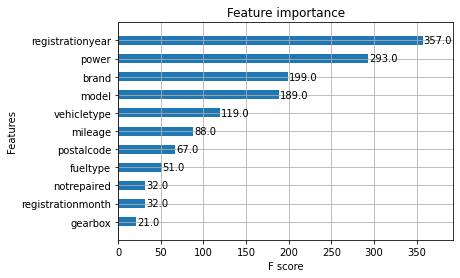

In [84]:
plot_importance(model_xgb_best, height=0.5)
plt.show()

## Model analysis

In [154]:
scores_times = [['Linear Regression', rmse_lr, train_time_lr, predict_time_lr], 
              ['Decision Tree Regressor', rmse_dt, train_time_dt, predict_time_dt],
             ['Random Forest Regressor', rmse_rf, train_time_rf, predict_time_rf],
             ['LightGBM', rmse_lgb, train_time_lgb, predict_time_lgb],
             ['CatBoost', rmse_cat, train_time_cat, predict_time_cat],
             ['XGBoost', rmse_xgb, train_time_xgb, predict_time_xgb]]

comparison = pd.DataFrame(scores_times, columns=['model_name', 'RMSE', 'training_time_s', 'predict_time_s'])
comparison['RMSE'] = round(comparison['RMSE'],2)
comparison.sort_values(by=['RMSE', 'training_time_s', 'predict_time_s'], ascending=[True, False, False])

,model_name,RMSE,training_time_s,predict_time_s
3,LightGBM,298.97,114.0,6.30000
4,CatBoost,304.52,194.0,0.08900
5,XGBoost,321.52,243.0,0.15900
2,Random Forest Regressor,367.25,801.0,0.59800
1,Decision Tree Regressor,384.20,18.1,0.00984
0,Linear Regression,2722.28,14.1,0.09880


## Conclusions
- The 3 Gradient Boosting models performed better than the other models.
- The Random Forest Regressor has the longest training time whereas LighGBM has the longest prediction time.
- All models performed significantly better than the baseilne linear regression model.
- LightGBM has the lowest RMSE of \$298.97, but also has the longest prediction time of all models.
- CatBoost is the recommended model since the RMSE is $304.52, just ~1.8% higher than LightGBM's but with a 70x faster prediction speed. The trade-off is a 70% longer training time than LightGBM, but it is still faster than the XGBoost model's traning time by about 25% and prediction time by 78%.
